# Demo

XGBoost with 1D-CNN for dimensionality reduction for simulated data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

import dataloader
import models
import util

In [3]:
Bakken = dataloader.DataLoader(verbose=False)
x_train, x_test, y_train, y_test, y_cumm_train, y_cumm_test = Bakken.get_data_split()

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, y_cumm_train.shape, y_cumm_test.shape)

(480, 6) (120, 6) (480, 60, 3) (120, 60, 3) (480,) (120,)


# Display input and output data

(600, 6)
(600, 60, 3)


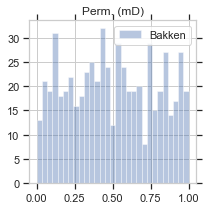

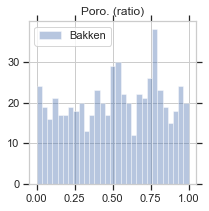

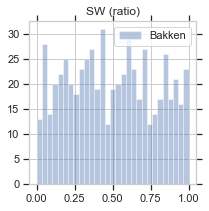

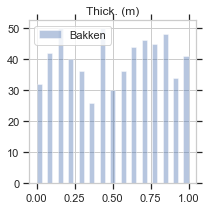

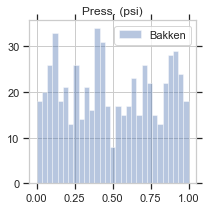

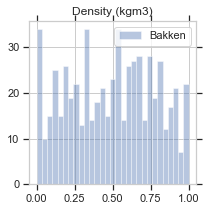

In [4]:
#field data: input and output data to plot
print(Bakken.x.shape)
print(Bakken.y.shape)

#col_names = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
col_names = ['Perm. (mD)', 'Poro. (ratio)', 'SW (ratio)', 'Thick. (m)', 'Press. (psi)', 'Density (kgm3)']
y_lims = [0.0008, 2e-6, 4e-7, 0.0015, 0.1, 0.08]

#function to plot the density plot
def histplot(data1, col_name, y_lim):
    new_bins = np.linspace(np.min(data1), np.max(data1), 30)
    ax = sns.set(style="whitegrid", rc={'figure.figsize':(3, 3)})
    plt.figure()
    sns.distplot(data1, hist=True, bins=new_bins, norm_hist=False, kde=False)
    plt.legend(['Bakken'])
    #plt.ylim([0, y_lim])
    plt.tick_params(axis='both', which='both', bottom='on', top='off', labelbottom='on', right='off', left='on', labelleft='off')
    plt.title(col_name)
    
for idx, feature in enumerate(col_names):
    histplot(Bakken.x[:,idx], feature, y_lims[idx])

Text(0.5, 1.0, 'Water rates')

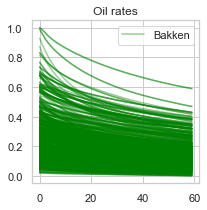

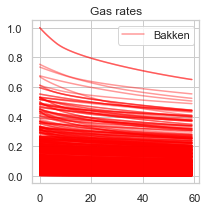

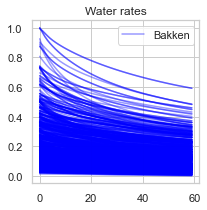

In [5]:
#field data: display the output data

plt.figure(figsize=[3, 3])
for i in range(Bakken.y.shape[0]):
    plt.plot(Bakken.y[i, :, 0], c='green', alpha=0.4)
plt.legend(['Bakken'])
plt.title('Oil rates')

plt.figure(figsize=[3, 3])
for i in range(Bakken.y.shape[0]):
    plt.plot(Bakken.y[i, :, 1], c='red', alpha=0.4)   
plt.legend(['Bakken'])
plt.title('Gas rates')

plt.figure(figsize=[3, 3])
for i in range(Bakken.y.shape[0]):
    plt.plot(Bakken.y[i, :, 2], c='blue', alpha=0.4)
plt.legend(['Bakken'])
plt.title('Water rates')

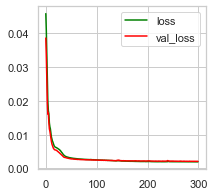

In [6]:
#reduce dimension of data

z_dim = 1
data_ae = models.models(name = 'data_ae',
                          z_dim = z_dim, 
                          timesteps = y_train.shape[1], 
                          n_features = y_train.shape[-1])

data_ae.train_autoencoder1D(y_train, load = False, epoch=300)

In [7]:
#qc reconstruction quality
y_train_hat = data_ae.d2d.predict(y_train)
y_test_hat = data_ae.d2d.predict(y_test)

z_y_train = data_ae.d2zd.predict(y_train)
z_y_test = data_ae.d2zd.predict(y_test)

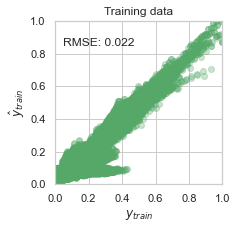

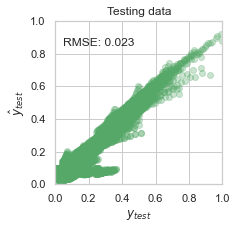

In [8]:
def RMSE(data1, data2):
    return np.sqrt(np.mean((data1.flatten()-data2.flatten())**2)) /2

#scatter plots for training and testing, color by field label
def scatterPlot(data1, data2, xlabel, ylabel, title, limits=True, c=None):
    fig, ax = plt.subplots(figsize=(3, 3))
    if c is None:
        plt.scatter(data1, data2, c='g', alpha=0.3)
    else:
        plt.scatter(data1, data2, c=c, alpha=0.9, cmap="seismic")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if limits:
        plt.xlim([0, 1])
        plt.ylim([0, 1])
    plt.title(title)
    ax.annotate(f"RMSE: {RMSE(data1, data2):.3f}", xy=(0.8, 0.8),  xycoords='data',
            xytext=(0.05, 0.9), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top')
    
scatterPlot(y_train, y_train_hat, '$y_{train}$', '$\hat{y}_{train}$', 'Training data')
scatterPlot(y_test, y_test_hat, '$y_{test}$', '$\hat{y}_{test}$', 'Testing data')

In [9]:
#display latent space with cumm production
scatterPlot(z_y_train[:, 0], z_y_train[:, 1], '$z1_{y_{train}}$', '$z2_{y_{train}}$', 'Training data', limits=False, c=y_cumm_train)

IndexError: index 1 is out of bounds for axis 1 with size 1

# XGBoost

In [10]:
import xgboost as xgb

#data
print(x_train.shape, z_y_train.shape)
print(x_test.shape, z_y_test.shape)

(480, 6) (480, 1)
(120, 6) (120, 1)


[12:30:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0.5, 1.0, 'Feature Importance')

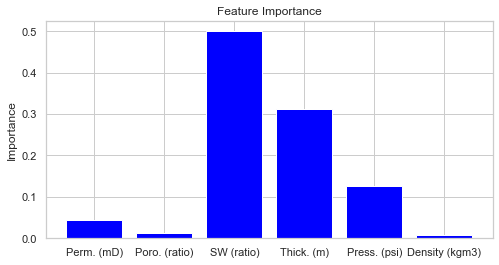

In [11]:
#XGBoost regression model
regressor = xgb.XGBRegressor(
    n_estimators=200,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

regressor.fit(x_train, z_y_train)

#get feature importance
pd.DataFrame(regressor.feature_importances_.reshape(1, -1), columns=col_names)

plt.figure(figsize=(8, 4))
plt.bar(col_names, regressor.feature_importances_, color="blue")
plt.ylabel("Importance")
plt.title("Feature Importance")

(480,) (120,)


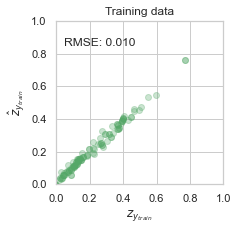

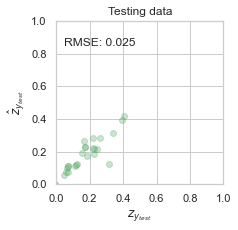

In [12]:
#get predictions
z_y_train_hat = regressor.predict(x_train)
z_y_test_hat = regressor.predict(x_test)

print(z_y_train_hat.shape, z_y_test_hat.shape)

scatterPlot(z_y_train, z_y_train_hat, '$z_{y_{train}}$', '$\hat{z}_{y_{train}}$', 'Training data')
scatterPlot(z_y_test, z_y_test_hat, '$z_{y_{test}}$', '$\hat{z}_{y_{test}}$', 'Testing data')

In [15]:
#plot prediction profile vs reference profile
y_test_hat_pred = data_ae.zd2d.predict(z_y_test_hat)

#predicted from latent space
print(y_test_hat_pred.shape)
#reconstructed from autoencoder
print(y_test_hat.shape)
#actual simulated profile
print(y_test.shape)

(120, 60, 3)
(120, 60, 3)
(120, 60, 3)


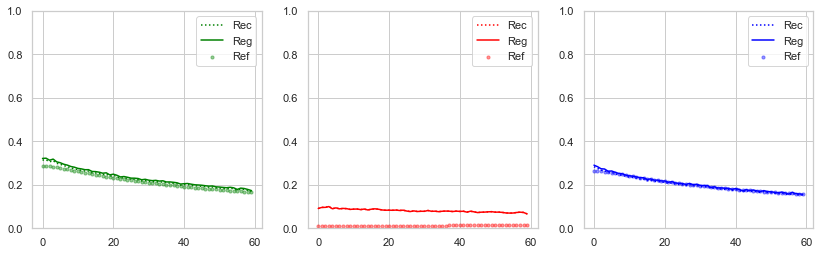

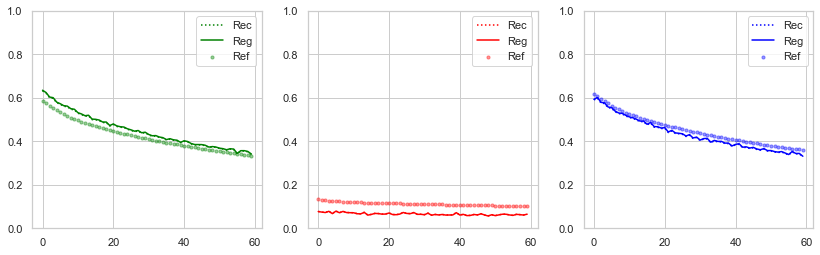

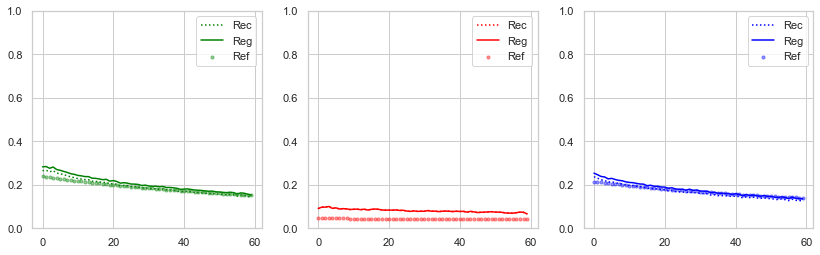

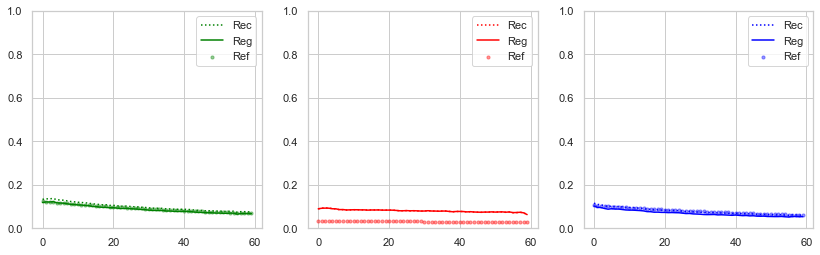

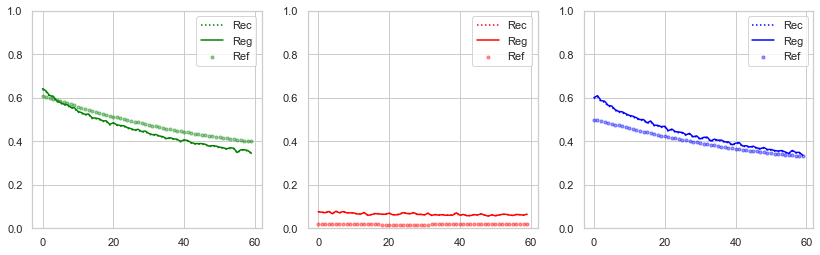

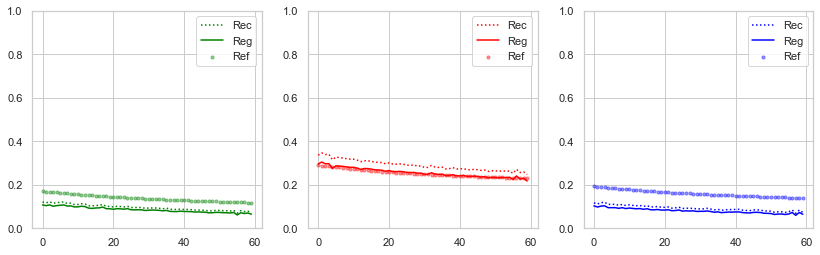

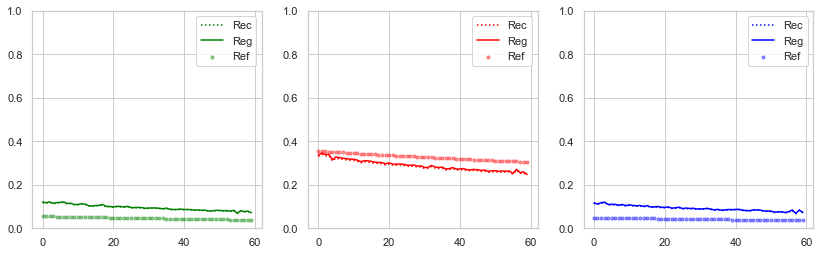

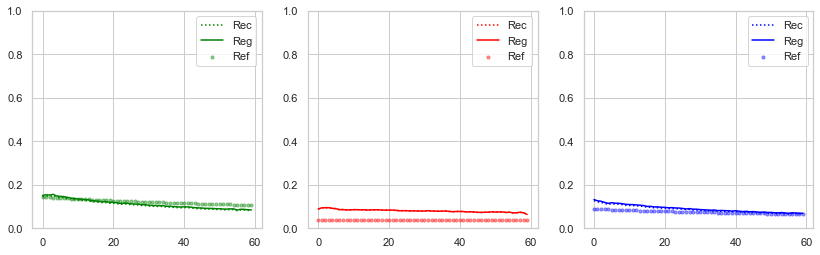

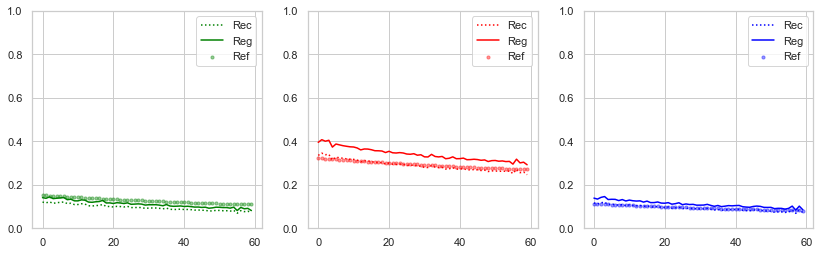

In [17]:
#compare some production profiles
def compareProfiles(well_idx, data_ref, data_recon, data_reg):

    timesteps = np.linspace(0, data_ref.shape[1]-1, data_ref.shape[1])
    plt.figure(figsize=[14, 4])
    plt.subplot(1, 3, 1)
    plt.scatter(timesteps, data_ref[well_idx, :, 0], c='green', s=10, alpha=0.4, label='Ref')
    plt.plot(timesteps, data_recon[well_idx, :, 0], c='green', ls=':',  label='Rec')
    plt.plot(timesteps, data_reg[well_idx, :, 0], c='green', label='Reg')
    plt.ylim([0, 1])
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(timesteps, data_ref[well_idx, :, 1], c='red', s=10, alpha=0.4, label='Ref')
    plt.plot(timesteps, data_recon[well_idx, :, 1], c='red', ls=':', label='Rec')
    plt.plot(timesteps, data_reg[well_idx, :, 1], c='red', label='Reg')
    plt.ylim([0, 1])
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.scatter(timesteps, data_ref[well_idx, :, 2], c='blue', s=10, alpha=0.4, label='Ref')
    plt.plot(timesteps, data_recon[well_idx, :, 2], c='blue', ls=':', label='Rec')
    plt.plot(timesteps, data_reg[well_idx, :, 2], c='blue', label='Reg')
    plt.ylim([0, 1])
    plt.legend()
    
#plot for some cases
cases = [0, 3, 4, 5, 6, 7, 8, 9, 10]
for case in cases:
    compareProfiles(case, y_test, y_test_hat, y_test_hat_pred)